<a href="https://colab.research.google.com/github/jordanlauritzen2/CRFR_Sp24_Project/blob/main/CRFR_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessing Fire and Rescue Service Strain to Anticipate Emerging Service Demands

## Files Required:

The following files (all located in the 'Data' folder) are required for the notebook to run:

*   2012_2021_NewData.xlsx
*   Acutal_ValueBY_Year.csv
*   HomeType.csv
*   FIREDISTRICT.shp **
*   FIRESTATIONS.shp **
*   FIRESTATIONZONES.shp **
*   Parcel.shp **
*   Blockgroups.shp **
*   Population files *
      *   Contains 9 csv files for 2013-2021
*   Homes65+ files *
      *   Contains 9 csv files for 2013-2021
*   Blockgroups files *
      *   Contains 10 .shp files


<br>
<br>
<br>

*Entire folder is required



** For all shapefiles `.shp` the corresponding `.cpg`, `.dbf`, `.prj`, `.shx`, `.xml` are required

## Roles of Team Members

Sophie
> Words

Jordan:
> Words

Glen:
> Coding and some non-coding analysis


# Abstract

Words

# Introduction

Words

# Methods

## Python dependencies

In [1]:
%pip install geopandas -q
%pip install mapclassify -q
%pip install contextily -q
%pip install cpi -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 17.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import mapclassify
import contextily as cx
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn.linear_model import LinearRegression
from cpi import inflate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from calendar import month_abbr
from functools import reduce
import scipy as sp
from statsmodels.formula.api import ols
from IPython.display import display, clear_output
import plotly.graph_objects as go


from typing import Optional


# importing widget stuff
from ipywidgets import interact, widgets

# Results and Discussion

this is copied from previous project

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cwd = os.getcwd()
pathCRFR = cwd + '/drive/My Drive/Colab Notebooks/Math Clinic/'
filepath = pathCRFR
os.listdir(filepath)

['Acutal_ValueBY_Year.csv',
 'HomeType.csv',
 'Incident_Data_CLEAN.xlsx',
 '2012_2021_NewData.xlsx',
 'Blockgroups',
 'Population',
 'ShapeFiles',
 'Homes65+']

## Functions

In [106]:
def pop_dfs_cleaning(df):
    df = df.iloc[:, [0,2]] # Removes all but two columns
    df = df.drop(labels = 0, axis=0) # Drop first column label
    df = df.set_index('GEO_ID') # Rename column label
    df = df.rename(index = lambda x: x[9:]) # Remove first 9 chrs.
    return df

In [107]:
def old_dfs_cleaning(df, i):
    df = df.iloc[:, [0,2,6, 26]] # Removes useless columns
    df = df.drop(labels = 0, axis=0) # Drop first column label

    # Renames columns by year
    year = old_years[i]
    df = df.rename(columns={'B11007_001E':f'Total_households_{year}', 'B11007_002E':f'Households_with_65+_{year}', 'B11007_007E':f'Households_without_65+_{year}'})

    # Rename column label and remove first 9 chrs.
    df = df.set_index('GEO_ID')
    df = df.rename(index = lambda x: x[9:])
    return df

In [108]:
square_ft2mi = 1/(5280)**2

## Importing Data

### Incident Data

In [176]:
incident_data = pd.read_excel(filepath + '2012_2021_NewData.xlsx').drop(columns = 'Jurisdiction Name')

In [177]:
# Columns with spaces rewritten with _ for calling them
incident_data = incident_data.rename(columns = {'Incident Year':'incident_year',
                                'Incident Number':'incident_number',
                                'Date of Call':'date_of_call',
                                'Day of Week':'day_of_week',
                                'Time of Call':'time_of_call',
                                'Hour of Day':'hour_of_day',
                                'Incident Type':'incident_type',
                                'Incident Type Category':'incident_type_category',
                                'Location from CAD':'location_from_cad',
                                'Response Zone':'response_zone',
                                'Station District':'station_district'})

### Actual Value Data (home values)

In [178]:
actual_value_df = pd.read_csv(filepath + 'Acutal_ValueBY_Year.csv', sep = ',')

In [179]:
actual_value_df = actual_value_df.replace('<Null>', np.nan) # Changes <Null> to NaN that pandas recognizes
actual_value_df.drop(actual_value_df.columns[[13,14]],axis=1,inplace=True) # Drops empty columns 13, 14
actual_value_df = actual_value_df.dropna() # Drops empty rows

### Home Type

SFD = Single Family Dwelling \\
SFA = Service Family Accomodation \\
MF = Multifamily dwelling \\

In [180]:
home_type_df = pd.read_csv(filepath + 'HomeType.csv', sep = ',').dropna()

### Population Tables (census data from past project)

In [181]:
# Creates list of filenames
pop_files = glob.glob(filepath + 'Population/' + '*.csv')
list_pop_dfs = []

# Reads in each file and adds to list
for filename in pop_files:
    pop_df = pd.read_csv(filename)
    list_pop_dfs.append(pop_df)

In [182]:
# For each df in that list, apply cleaning function and add to new list
clean_list_pop_dfs = []
for df in list_pop_dfs:
    clean_list_pop_dfs.append(pop_dfs_cleaning(df))

# Concatenate those dfs into one, and delete large list
pop_df = pd.concat(clean_list_pop_dfs, axis=1)
del clean_list_pop_dfs
pop_df

,pop_est_2013,pop_est_2014,pop_est_2015,pop_est_2016,pop_est_2017,pop_est_2018,pop_est_2019,pop_est_2020,pop_est_2021
GEO_ID,,,,,,,,,
080350139011,1257,1208,1170,1346,1566,1235,1416,NaN,NaN
080350139012,1536,1670,1737,1638,2192,2298,2344,NaN,NaN
080350139013,1334,1660,1744,2166,1918,1841,1980,NaN,NaN
080350139014,2234,2266,2355,2360,2022,2154,2067,NaN,NaN
080350139041,1477,1742,1718,1464,1507,1487,1457,1349,1416
...,...,...,...,...,...,...,...,...,...
080350144104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1199,1359
080350144105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194,598
080350144106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1449,1198


In [183]:
pop_df.reset_index(inplace=True)
pop_df = pd.wide_to_long(pop_df, stubnames='pop_est_', i='GEO_ID' , j='year')
pop_df.reset_index(inplace=True)
pop_df = pop_df.rename(columns={'GEO_ID':'GEOID', 'pop_est_':'pop_est'})
pop_df = pop_df.set_index(['GEOID', 'year'])
pop_df

,,pop_est
GEOID,year,
080350139011,2013,1257
080350139012,2013,1536
080350139013,2013,1334
080350139014,2013,2234
080350139041,2013,1477
...,...,...
080350144104,2021,1359
080350144105,2021,598
080350144106,2021,1198


### Age Demographics (census data from past project)

### Shape Files

In [184]:
bg_files = glob.glob(filepath + 'Blockgroups/' + '*.shp')
list_bgs = []
bgs_years = []
for filename in bg_files:
   bg_shp = gpd.read_file(filename)
   list_bgs.append(bg_shp)
   bgs_years.append(filename[-18:-14]) # keeps year from file name)

In [185]:
fs_zones_gdf = gpd.read_file(filepath + 'ShapeFiles/FIRESTATIONZONES.shp')
firestations_gdf = gpd.read_file(filepath + 'ShapeFiles/FIRESTATIONS.shp')
fs_districts_gdf = gpd.read_file(filepath + 'ShapeFiles/FIREDISTRICT.shp')

In [186]:
parcels_douglas_gdf = gpd.read_file(filepath + 'ShapeFiles/Parcel.shp')

In [187]:
fs_zones_gdf = fs_zones_gdf.to_crs(epsg=4326) # reprojecting to all be the same
firestations_gdf = firestations_gdf.to_crs(epsg=4326)
fs_districts_gdf = fs_districts_gdf.to_crs(epsg=4326)
parcels_douglas_gdf = parcels_douglas_gdf.to_crs(epsg=4326)
for shp in list_bgs:
  if shp.crs != "epsg:4326":
    shp = shp.to_crs(epsg=4326)

In [188]:
parcels_fsarea = gpd.overlay(parcels_douglas_gdf, fs_districts_gdf, how="intersection") #cutting file down to only fire station area

In [189]:
parcels_fsarea = parcels_fsarea.rename(columns={'PARCEL_SPN': 'SPN'}) # renaming columns to be able to join
parcels_fsarea = parcels_fsarea.join(actual_value_df, lsuffix='_par', rsuffix='_val') # joining home values to parcel shape file
home_type_df = home_type_df.rename(columns = {'STATE_PARC': 'SPN_par'})
home_type_df = home_type_df.rename(columns = {'OBJECTID': 'OBJECTID_home'})
parcels_fsarea = parcels_fsarea.join(home_type_df, lsuffix='_2', rsuffix='_home') # joining home type to parcel shape file

In [190]:
parcels_fsarea.head()

,OBJECTID,SPN_par_2,DEEDED_ARE,CALC_AREA,LEGAL_DESC,PARCEL_NAM,BLOCK_NO,SHAPESTAre,FIREDIST,SOURCE,...,AV_2017,AV_2018,AV_2019,AV_2020,AV_2021,OBJECTID_home,SPN_par_home,Bldg_Type,Housing_Code,Occupany
0,36,250501101053,0.240,0.238267,LOT 25 BLOCK 3 THE WOODLANDS FILING 12 0.24 AM/L,25,3,10378.916504,CASTLE ROCK FD,DOUGLAS,...,527102,527102,665138,665138,614156,1.0,250501101053,Residential,SFD,3.02
1,41,250521006044,0.138,0.136932,LOT 22 BLK 2 DAWSON RIDGE #11 .138 AM/L,22,2,5964.757324,CASTLE ROCK FD,DOUGLAS,...,1800000,1800000,1883520,1883520,2077258,NaN,NaN,NaN,NaN,NaN
2,44,250534005006,5.010,5.007581,LOT 151 BELL MOUNTAIN RANCH #1B 5.010 AM/L,151,0,218130.220703,CASTLE ROCK FD,DOUGLAS,...,854,854,894,894,931,3.0,250534005006,Residential,SFD,3.02
3,118,250708412045,0.092,0.095548,LOT 22 BLOCK 3 CASTLEWOOD RANCH FLG 1 PARCEL 1...,22,3,4162.078125,CASTLE ROCK FD,DOUGLAS,...,561578,561578,996768,996768,1037026,4.0,250708412045,Residential,SFA,2.50
4,119,250709301020,0.298,0.295247,LOT 23 BLOCK 1 CASTLEWOOD RANCH FILING #2 PARC...,23,1,12860.937500,CASTLE ROCK FD,DOUGLAS,...,1198144,1198144,1320898,1320898,1416166,5.0,250709301020,Residential,SFD,3.02


In [191]:
geometry = gpd.points_from_xy(incident_data.Longitude, incident_data.Latitude, crs="EPSG:4326") # creating points for each call for service
incidents_gdf = gpd.GeoDataFrame(incident_data,crs="EPSG:4326", geometry=geometry) # creating geodataframe for incident data

In [192]:
incidents_homevalues = incidents_gdf.sjoin(parcels_fsarea, how='left') #spatial join, adding parcel information to each call point

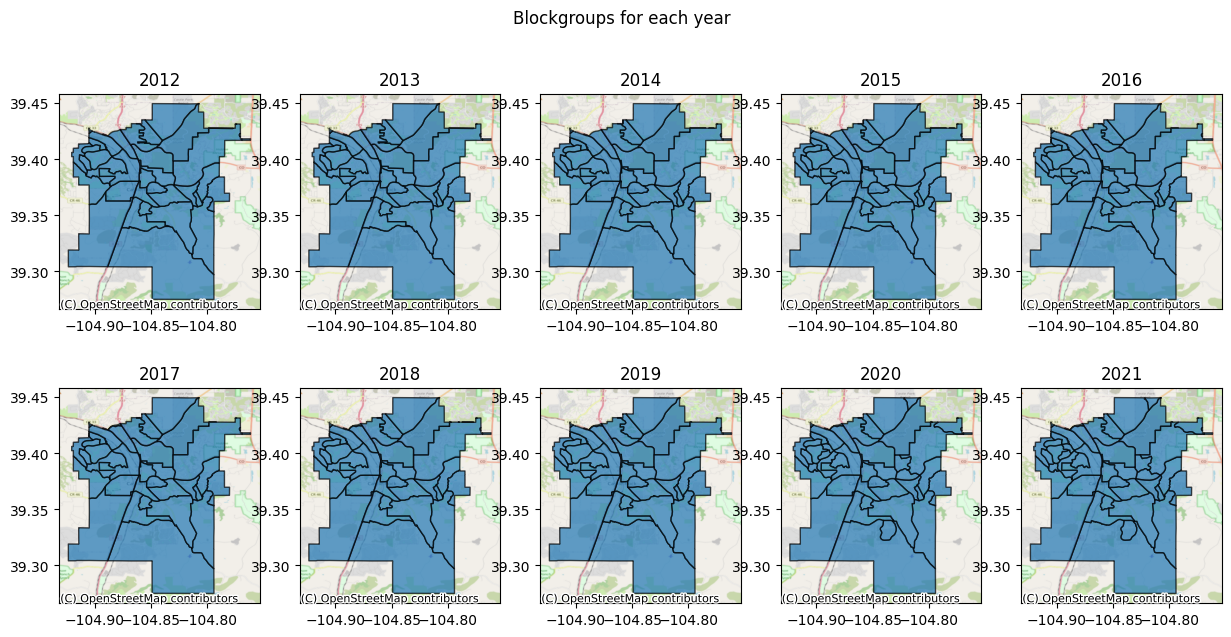

In [193]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,7))
fig.suptitle("Blockgroups for each year")

for i, (shp, ax) in enumerate(zip(list_bgs, axs.ravel())):
  ax2 = shp.plot(ax=ax, alpha=0.7, edgecolor='black')
  cx.add_basemap(ax2, crs=4326, source=cx.providers.OpenStreetMap.Mapnik)
  ax2.set_title(bgs_years[i])

In [194]:
# Creates list of filenames
old_files = glob.glob(filepath + 'Homes65+/' + '*.csv')
list_old_dfs = []
old_years = []

# Reads in each file and adds to list
for filename in old_files:
  old_df = pd.read_csv(filename)
  list_old_dfs.append(old_df)
  old_years.append(filename[-20:-16]) # saves the year (string) from the filename to a list of years

In [195]:
# For each df in that list, apply cleaning function and add to new list
clean_list_old_dfs = []
for i, df in enumerate(list_old_dfs):
  clean_list_old_dfs.append(old_dfs_cleaning(df, i))

# Concatenate those dfs into one, and delete large list
old_df = pd.concat(clean_list_old_dfs, axis=1)
del clean_list_old_dfs
old_df

,Total_households_2013,Households_with_65+_2013,Households_without_65+_2013,Total_households_2015,Households_with_65+_2015,Households_without_65+_2015,Total_households_2020,Households_with_65+_2020,Households_without_65+_2020,Total_households_2018,...,Households_without_65+_2019,Total_households_2021,Households_with_65+_2021,Households_without_65+_2021,Total_households_2014,Households_with_65+_2014,Households_without_65+_2014,Total_households_2017,Households_with_65+_2017,Households_without_65+_2017
GEO_ID,,,,,,,,,,,,,,,,,,,,,
080350139011,732,137,595,739,171,568,NaN,NaN,NaN,691,...,614,NaN,NaN,NaN,705,154,551,951,211,740
080350139012,714,224,490,710,250,460,NaN,NaN,NaN,714,...,535,NaN,NaN,NaN,696,272,424,701,213,488
080350139013,522,274,248,668,321,347,NaN,NaN,NaN,764,...,373,NaN,NaN,NaN,620,295,325,796,413,383
080350139014,657,28,629,728,67,661,NaN,NaN,NaN,670,...,594,NaN,NaN,NaN,658,17,641,631,46,585
080350139041,589,64,525,637,75,562,550,76,474,552,...,495,582,71,511,638,67,571,566,73,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
080350144104,NaN,NaN,NaN,NaN,NaN,NaN,387,113,274,NaN,...,NaN,438,141,297,NaN,NaN,NaN,NaN,NaN,NaN
080350144105,NaN,NaN,NaN,NaN,NaN,NaN,81,0,81,NaN,...,NaN,298,0,298,NaN,NaN,NaN,NaN,NaN,NaN
080350144106,NaN,NaN,NaN,NaN,NaN,NaN,502,106,396,NaN,...,NaN,490,108,382,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
old_df.reset_index(inplace=True)
old_df = pd.wide_to_long(old_df, stubnames=['Total_households_', 'Households_with_65+_', 'Households_without_65+_'], i='GEO_ID', j='year')
old_df.reset_index(inplace=True)
old_df = old_df.rename(columns={'GEO_ID':'GEOID', 'Total_households_':'Total_households', 'Households_with_65+_':'Households_with_65+', 'Households_without_65+_':'Households_without_65+'})
old_df = old_df.set_index(['GEOID', 'year'])
old_df['Total_households'] = pd.to_numeric(old_df['Total_households'])
old_df['Households_with_65+'] = pd.to_numeric(old_df['Households_with_65+'])
old_df['Percent_households_with_65+'] = old_df['Households_with_65+']/old_df['Total_households']*100
old_df

,,Total_households,Households_with_65+,Households_without_65+,Percent_households_with_65+
GEOID,year,,,,
080350139011,2013,732.0,137.0,595,18.715847
080350139012,2013,714.0,224.0,490,31.372549
080350139013,2013,522.0,274.0,248,52.490421
080350139014,2013,657.0,28.0,629,4.261796
080350139041,2013,589.0,64.0,525,10.865874
...,...,...,...,...,...
080350144104,2017,NaN,NaN,NaN,NaN
080350144105,2017,NaN,NaN,NaN,NaN
080350144106,2017,NaN,NaN,NaN,NaN


## Dataframes

### Main Dataframe

We first determine the number of calls per block group by counting the incidents within each block group in each year.

In [197]:
incidents_homevalues = incidents_homevalues.rename(columns={'index_right': 'index_before'})

In [198]:
bgs_years = pd.to_numeric(bgs_years)
num_inc_dfs = []
for i, shp in enumerate(list_bgs):
  incidents = incidents_homevalues[incidents_homevalues['incident_year'] == bgs_years[i]]
  incidents_bg = incidents.sjoin(shp, how='left')
  num_inc = incidents_bg[['GEOID', 'incident_year', 'incident_number']]
  num_inc = num_inc.groupby(['GEOID', 'incident_year']).incident_number.count()
  num_inc = num_inc.reset_index()
  num_inc = num_inc.rename(columns={"incident_number":"Number_of_calls", "incident_year":"year"})
  num_inc = num_inc.set_index(['GEOID', 'year'])
  num_inc_dfs.append(num_inc)

In [199]:
num_inc_2 = pd.concat(num_inc_dfs)
num_inc_2

,,Number_of_calls
GEOID,year,
080350140121,2012,200
080350140122,2012,61
080350140123,2012,36
080350140131,2012,77
080350140132,2012,7
...,...,...
080350146031,2021,129
080350146032,2021,116
080350146033,2021,60


Next we find the average home value within each block group for each year.

In [200]:
cols = ['AV_2012','AV_2013','AV_2014','AV_2015','AV_2016','AV_2017','AV_2018','AV_2019','AV_2020','AV_2021']
parcels_fsarea[cols] = parcels_fsarea[cols].apply(pd.to_numeric, axis=1)

In [201]:
parcels_avgval = []
for i, shp in enumerate(list_bgs):
  parc_bg = parcels_fsarea.sjoin(shp, how='left')
  parc_avgval = parc_bg[['GEOID', f'AV_{bgs_years[i]}']]
  parc_avgval = parc_avgval.groupby('GEOID').mean()
  parc_avgval = parc_avgval.rename(columns = {f'AV_{bgs_years[i]}':'avg_homevalue'})
  parc_avgval['year'] = bgs_years[i]
  parc_avgval = parc_avgval.reset_index()
  parc_avgval = parc_avgval.set_index(['GEOID', 'year'])
  parcels_avgval.append(parc_avgval)

In [202]:
parcels_avgval_2 = pd.concat(parcels_avgval)
parcels_avgval_2

,,avg_homevalue
GEOID,year,
080350139091,2012,150183.250000
080350140121,2012,289119.326203
080350140122,2012,270729.147929
080350140123,2012,269802.923767
080350140131,2012,244639.238095
...,...,...
080350146031,2021,488044.218345
080350146032,2021,510943.357550
080350146033,2021,458067.049587


Next, we need to create population density from the population estimate variable we already have. We calculate the area of each block group, by projecting the blockgroups to epsg 2232, which corresponds to the NAD83 Colorado Central (ftUS) projection. This gives us the area in square ft, which is converted to square miles. We then divide the population estimate by the are to get population density.

In [203]:
pop_list = []
pop_df.reset_index(inplace=True)
for i, shp in enumerate(list_bgs[1:]):
  shp = shp.to_crs(epsg=2232)
  shp["area_ft"] = shp['geometry'].area
  shp["area_miles"] = shp["area_ft"]*square_ft2mi
  bg_subset = shp[['GEOID', 'area_miles']]
  pop_subset = pop_df[pop_df['year'] == bgs_years[i+1]]
  pop_subset = pop_subset.merge(bg_subset, how='right', on=['GEOID'])
  pop_subset['pop_est'] = pd.to_numeric(pop_subset['pop_est'])
  pop_subset['pop_density'] = pop_subset['pop_est']/pop_subset['area_miles']
  pop_subset = pop_subset.set_index(['GEOID', 'year'])
  pop_list.append(pop_subset)

In [204]:
pop_df_2 = pd.concat(pop_list)
pop_df_2

,,pop_est,area_miles,pop_density
GEOID,year,,,
080350140132,2013,2433,3.476816,699.778162
080350145031,2013,2263,0.955606,2368.130121
080350146042,2013,1875,1.297171,1445.453564
080350139091,2013,2656,0.046124,57583.366751
080350146031,2013,3112,1.262519,2464.913741
...,...,...,...,...
080350146032,2021,3059,0.712836,4291.309753
080350146033,2021,1537,0.195334,7868.589660
080350144054,2021,1766,0.296951,5947.100130


Finally these dataframes are merged together to get one dataframe with all the variables that we want. We also account for inflation in the average homevalues with the last line of code, but converting previous years pricing to current day dollars.

In [205]:
pop_sub = pop_df_2[['pop_density', 'pop_est']]
old_sub = old_df[['Percent_households_with_65+']]
model_df = parcels_avgval_2.merge(pop_sub, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(num_inc_2, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(old_sub, how='left', on=['GEOID', 'year'])
model_df.reset_index(inplace=True)
model_df['avg_homevalue'] = model_df.apply(lambda x: inflate(x['avg_homevalue'], x['year'], to=2021), axis = 1)

In [206]:
model_df

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
0,080350139091,2012,177248.339471,NaN,NaN,NaN,NaN
1,080350140121,2012,341222.609569,NaN,NaN,200.0,NaN
2,080350140122,2012,319518.267961,NaN,NaN,61.0,NaN
3,080350140123,2012,318425.125452,NaN,NaN,36.0,NaN
4,080350140131,2012,288726.597153,NaN,NaN,77.0,NaN
...,...,...,...,...,...,...,...
350,080350146031,2021,488044.218345,2448.513286,3091.0,129.0,15.487179
351,080350146032,2021,510943.357550,4291.309753,3059.0,116.0,7.560976
352,080350146033,2021,458067.049587,7868.589660,1537.0,60.0,9.810671
353,080350146041,2021,526479.161950,602.387145,2272.0,83.0,15.217391


Because we calculated the area of the blockgroups, certain blockgroups on the edge of our area of study are cut off and have a smaller calculated area than what the actual block group has. Using the population estimate from the census with these incorrect areas caused huge population densities, and so we need to exclude these blockgroups from the data set by filtering them out.

In [207]:
model_df = model_df[model_df['pop_density'] < 20000]
model_df

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
34,080350140121,2013,344706.126856,1375.564201,1792.0,231.0,31.508678
35,080350140122,2013,328142.885112,1310.003867,4177.0,68.0,2.150538
36,080350140123,2013,318879.817841,977.118467,883.0,17.0,8.026756
37,080350140131,2013,297095.492427,287.310682,1641.0,87.0,15.697674
38,080350140132,2013,272272.177751,699.778162,2433.0,6.0,10.428571
...,...,...,...,...,...,...,...
350,080350146031,2021,488044.218345,2448.513286,3091.0,129.0,15.487179
351,080350146032,2021,510943.357550,4291.309753,3059.0,116.0,7.560976
352,080350146033,2021,458067.049587,7868.589660,1537.0,60.0,9.810671
353,080350146041,2021,526479.161950,602.387145,2272.0,83.0,15.217391


### Standarized Dataframe

Below we create a dataframe where we standardize the variables within each year, to examine if the data is stationary over the years.

In [208]:
standard_dfs = []
model_stand = model_df.copy()
for year in bgs_years[1:]:
  model_stand.loc[model_stand['year'] == year, 'avg_homevalue'] = (model_stand.loc[model_stand['year'] == year, 'avg_homevalue'] - model_stand.loc[model_stand['year'] == year, 'avg_homevalue'].mean()) / model_stand.loc[model_stand['year'] == year, 'avg_homevalue'].std()
  model_stand.loc[model_stand['year'] == year, 'pop_density'] = (model_stand.loc[model_stand['year'] == year, 'pop_density'] - model_stand.loc[model_stand['year'] == year, 'pop_density'].mean()) / model_stand.loc[model_stand['year'] == year, 'pop_density'].std()
  model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'] = (model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'] - model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'].mean()) / model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'].std()
  model_stand.loc[model_stand['year'] == year, 'Number_of_calls'] = (model_stand.loc[model_stand['year'] == year, 'Number_of_calls'] - model_stand.loc[model_stand['year'] == year, 'Number_of_calls'].mean()) / model_stand.loc[model_stand['year'] == year, 'Number_of_calls'].std()
  standard_dfs.append(model_stand.loc[model_stand['year'] == year])

model_stand = pd.concat(standard_dfs)
model_df

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
34,080350140121,2013,344706.126856,1375.564201,1792.0,231.0,31.508678
35,080350140122,2013,328142.885112,1310.003867,4177.0,68.0,2.150538
36,080350140123,2013,318879.817841,977.118467,883.0,17.0,8.026756
37,080350140131,2013,297095.492427,287.310682,1641.0,87.0,15.697674
38,080350140132,2013,272272.177751,699.778162,2433.0,6.0,10.428571
...,...,...,...,...,...,...,...
350,080350146031,2021,488044.218345,2448.513286,3091.0,129.0,15.487179
351,080350146032,2021,510943.357550,4291.309753,3059.0,116.0,7.560976
352,080350146033,2021,458067.049587,7868.589660,1537.0,60.0,9.810671
353,080350146041,2021,526479.161950,602.387145,2272.0,83.0,15.217391


In [209]:
model_stand

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
34,080350140121,2013,-0.151415,-0.341787,1792.0,0.962566,1.411046
35,080350140122,2013,-0.274877,-0.373647,4177.0,-0.629527,-1.272946
36,080350140123,2013,-0.343924,-0.535416,883.0,-1.127667,-0.735728
37,080350140131,2013,-0.506303,-0.870634,1641.0,-0.443946,-0.034434
38,080350140132,2013,-0.691335,-0.670192,2433.0,-1.235109,-0.516148
...,...,...,...,...,...,...,...
350,080350146031,2021,-0.419217,-0.153914,3091.0,-0.129050,-0.520597
351,080350146032,2021,-0.334549,0.660996,3059.0,-0.228761,-1.248639
352,080350146033,2021,-0.530056,2.242918,1537.0,-0.658289,-1.041998
353,080350146041,2021,-0.277106,-0.970296,2272.0,-0.481876,-0.545378


In [210]:
pop_sub = pop_df_2[['pop_density', 'pop_est']]
old_sub = old_df[['Percent_households_with_65+']]
model_df = parcels_avgval_2.merge(pop_sub, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(num_inc_2, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(old_sub, how='left', on=['GEOID', 'year'])
model_df.reset_index(inplace=True)
model_df['avg_homevalue'] = model_df.apply(lambda x: inflate(x['avg_homevalue'], x['year'], to=2021), axis = 1)

## Exploratory Data Analysis

### Mapping

Text(0.5, 1.0, 'All Incidents (2013-2021) by Incident Type')

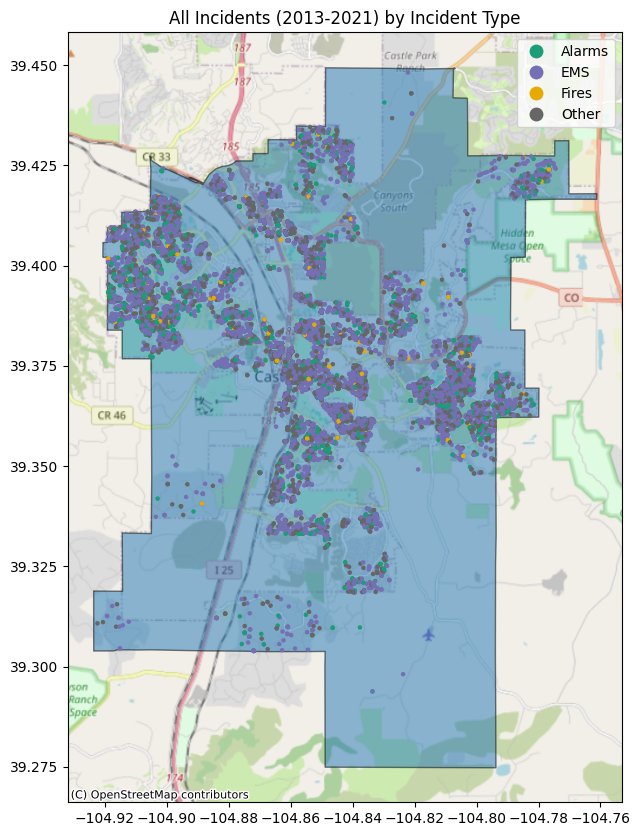

In [211]:
ax = fs_districts_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=4326, source=cx.providers.OpenStreetMap.Mapnik)
inc_hom_na = incidents_homevalues.dropna()
inc_hom_na.plot(ax=ax, column = 'incident_type_category', markersize=5, cmap='Dark2', legend=True)
plt.title("All Incidents (2013-2021) by Incident Type")

### Histograms

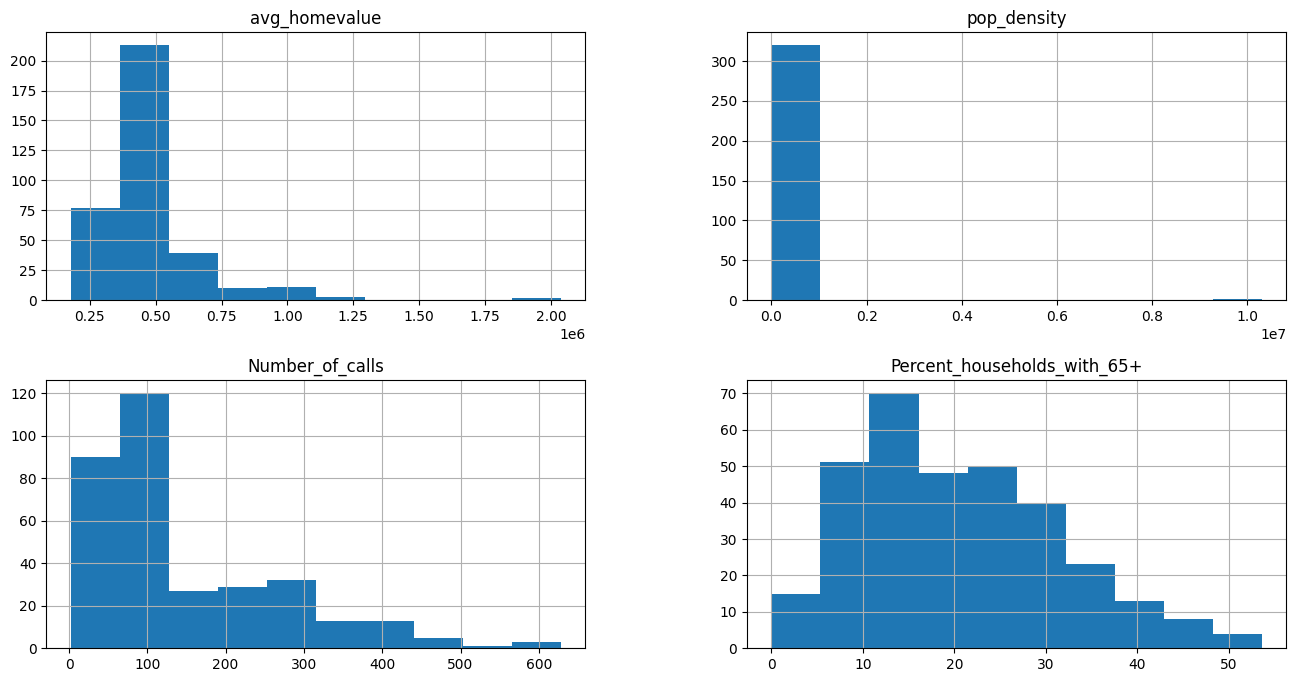

In [212]:
hist_model = model_df.copy()
hist_model = hist_model.drop(columns=['year', 'pop_est'])
histograms = hist_model.hist(figsize=(16,8))

### Density Plots

We see the same right skew in the population density from the histogram, with not much notable difference between the years.

# Playing With Some DATA

after we make it look better:

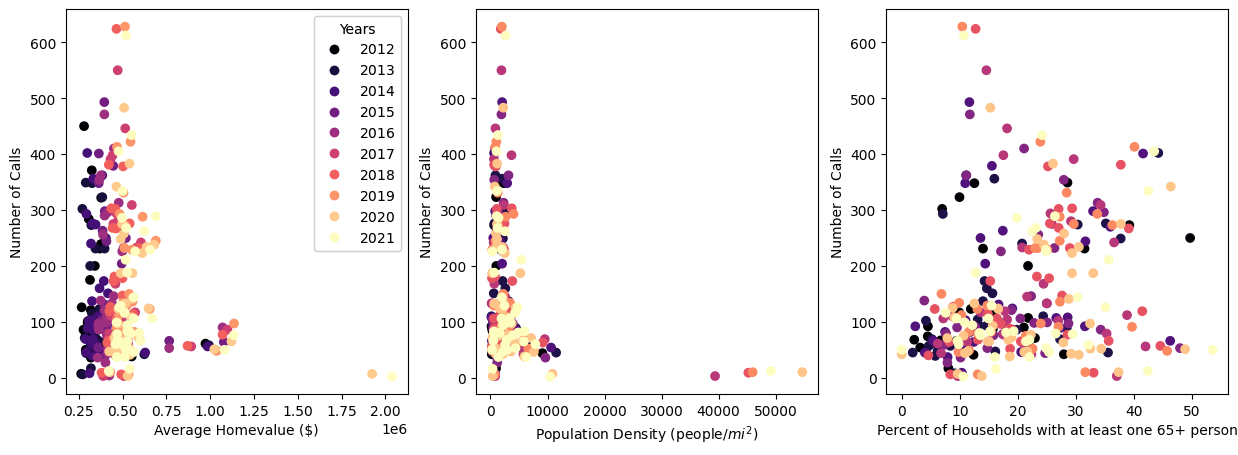

In [213]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Avg HV
scatter1 = ax[0].scatter(model_df['avg_homevalue'], model_df['Number_of_calls'], c=model_df['year'].astype('int32').array, cmap='magma')
legend = ax[0].legend(*scatter1.legend_elements(), title="Years")
ax[0].add_artist(legend)
ax[0].set_xlabel("Average Homevalue ($)")
ax[0].set_ylabel("Number of Calls")

# Pop density
scatter2 = ax[1].scatter(model_df['pop_density'], model_df['Number_of_calls'], c=model_df['year'], cmap='magma')
ax[1].set_xlabel("Population Density (people/${mi}^2$)")
ax[1].set_ylabel("Number of Calls")

# Old pop
scatter3 = ax[2].scatter(model_df['Percent_households_with_65+'], model_df['Number_of_calls'], c=model_df['year'], cmap='magma')
ax[2].set_xlabel("Percent of Households with at least one 65+ person")
ax[2].set_ylabel("Number of Calls")

plt.show()

In [214]:
model_df.head(10)

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
0,080350139091,2012,177248.339471,NaN,NaN,NaN,NaN
1,080350140121,2012,341222.609569,NaN,NaN,200.0,NaN
2,080350140122,2012,319518.267961,NaN,NaN,61.0,NaN
3,080350140123,2012,318425.125452,NaN,NaN,36.0,NaN
4,080350140131,2012,288726.597153,NaN,NaN,77.0,NaN
5,080350140132,2012,263302.756723,NaN,NaN,7.0,NaN
6,080350141232,2012,323828.571791,NaN,NaN,371.0,NaN
7,080350141351,2012,577002.577448,NaN,NaN,NaN,NaN
8,080350144032,2012,551596.537290,NaN,NaN,38.0,NaN
9,080350144033,2012,402509.687981,NaN,NaN,123.0,NaN


In [215]:
model_df.describe()

,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
count,355.000000,3.550000e+02,3.220000e+02,322.000000,333.000000,322.000000
mean,2016.760563,4.841697e+05,7.121587e+04,2101.978261,147.531532,20.461227
std,2.942312,1.975807e+05,7.870813e+05,907.277271,122.239235,10.837460
min,2012.000000,1.772483e+05,1.739629e+02,194.000000,2.000000,0.000000
25%,2014.000000,3.710784e+05,9.698949e+02,1537.250000,61.000000,11.782687
50%,2017.000000,4.618345e+05,1.949495e+03,1955.000000,99.000000,18.652822
75%,2019.000000,5.230859e+05,3.589538e+03,2566.000000,231.000000,27.288770
max,2021.000000,2.037466e+06,1.029679e+07,5843.000000,628.000000,53.600000


In [216]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GEOID                        355 non-null    object 
 1   year                         355 non-null    int64  
 2   avg_homevalue                355 non-null    float64
 3   pop_density                  322 non-null    float64
 4   pop_est                      322 non-null    float64
 5   Number_of_calls              333 non-null    float64
 6   Percent_households_with_65+  322 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 19.5+ KB


### Separating Scatterplots by Year


The previous project had created scatterplots that showed data from different years onto one graph, and we wanted to see if there were any changes to shape from year to year. So, we created new plots with sliders that allow us to go from year to year, seeing if there were any relationships worth exploring.

In [286]:
def plot_with_slider(df, x_variable, y_variable):
    '''
    Here we create a function that plots different variables against one another
    using a slider that changes the year.

    We can use this to save time if we decide to plot other variables
    that the previous team did not.
    '''
    fig = go.Figure()
    my_year = 2012
    year_visibility = []
    steps = []
    for i in range(10):
        fig.add_trace(
            go.Scatter(
                mode="markers",
                x=list(model_df[model_df['year'] == my_year + i][str(x_variable)]),
                y=list(model_df[model_df['year'] == my_year + i][str(y_variable)]),
                name=str(my_year + i),
                line=dict(color="#4a257a")))
        year_visibility.append(False)

    for i in range(10):
        year_visibility[i] = True
        steps.append(
            dict(
                method="update",
                args=[{"visible": year_visibility[:]}],
                label=str(my_year + i)))
        year_visibility[i] = False

    fig.update_layout(
        sliders=[{
            "active": 0,
            "steps": steps,
            "currentvalue": {"prefix": "Year: "},
            "pad": {"t": 50}
        }]
    )

    fig.update_layout(title=str(y_variable) + ' vs. ' + str(x_variable),
                      xaxis_title=str(x_variable), yaxis_title=str(y_variable))

    fig.show()

In [287]:
# Simply displaying that the function works
plot_with_slider(model_df, 'avg_homevalue', 'Number_of_calls')

In [269]:
# Avg. Homevalue
fig = go.Figure()
my_year = 2012
year_visibility = []
steps = []
for i in range(10):
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x=list(model_df[model_df['year'] == my_year + i]['avg_homevalue']),
            y=list(model_df[model_df['year'] == my_year + i]['Number_of_calls']),
            name=str(my_year + i),
            line=dict(color="#4a257a")))
    year_visibility.append(False)

for i in range(10):
    year_visibility[i] = True
    steps.append(
        dict(
            method="update",
            args=[{"visible": year_visibility[:]}],
            label=str(my_year + i)))
    year_visibility[i] = False

fig.update_layout(
    sliders=[{
        "active": 0,
        "steps": steps,
        "currentvalue": {"prefix": "Year: "},
        "pad": {"t": 50}
    }]
)

fig.update_layout(title="Service Calls vs. Average Homevalue",
                  xaxis_title="Average Home Value ($)", yaxis_title="Service Calls")

fig.show()

In [268]:
# Pop. Density
fig = go.Figure()
my_year = 2012
year_visibility = []
steps = []
for i in range(10):
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x=list(model_df[model_df['year'] == my_year + i]['pop_density']),
            y=list(model_df[model_df['year'] == my_year + i]['Number_of_calls']),
            name=str(my_year + i),
            line=dict(color="#4a257a")))
    year_visibility.append(False)

for i in range(10):
    year_visibility[i] = True
    steps.append(
        dict(
            method="update",
            args=[{"visible": year_visibility[:]}],
            label=str(my_year + i)))
    year_visibility[i] = False

fig.update_layout(
    sliders=[{
        "active": 0,
        "steps": steps,
        "currentvalue": {"prefix": "Year: "},
        "pad": {"t": 50}
    }]
)

fig.update_layout(title="Service Calls vs. Population Density",
                  xaxis_title="Population Density (people/mi^2)", yaxis_title="Service Calls")

fig.show()

In [270]:
# 65+ Pop
fig = go.Figure()
my_year = 2012
year_visibility = []
steps = []
for i in range(10):
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x=list(model_df[model_df['year'] == my_year + i]['Percent_households_with_65+']),
            y=list(model_df[model_df['year'] == my_year + i]['Number_of_calls']),
            name=str(my_year + i),
            line=dict(color="#4a257a")))
    year_visibility.append(False)

for i in range(10):
    year_visibility[i] = True
    steps.append(
        dict(
            method="update",
            args=[{"visible": year_visibility[:]}],
            label=str(my_year + i)))
    year_visibility[i] = False

fig.update_layout(
    sliders=[{
        "active": 0,
        "steps": steps,
        "currentvalue": {"prefix": "Year: "},
        "pad": {"t": 50}
    }]
)

fig.update_layout(title="Service Calls vs. Pct of Households w/ 65+",
                  xaxis_title="Percent of Households with at least one 65+ person", yaxis_title="Service Calls")

fig.show()

# Power Transforms

In [221]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot
from pandas import DataFrame

pt_bc = PowerTransformer(method= 'box-cox', standardize=False, copy=True)
pt_yj = PowerTransformer(method='yeo-johnson', standardize=False, copy=True)

In [222]:
ahv_df = parcels_avgval_2.merge(num_inc_2, how ='left', on=['GEOID', 'year'])
ahv_df

,,avg_homevalue,Number_of_calls
GEOID,year,,
080350139091,2012,150183.250000,NaN
080350140121,2012,289119.326203,200.0
080350140122,2012,270729.147929,61.0
080350140123,2012,269802.923767,36.0
080350140131,2012,244639.238095,77.0
...,...,...,...
080350146031,2021,488044.218345,129.0
080350146032,2021,510943.357550,116.0
080350146033,2021,458067.049587,60.0


In [223]:
# transforming data
transformed_data = pt_bc.fit_transform(ahv_df)
# convert the array back to a dataframe
dataset = DataFrame(transformed_data)

dataset

,0,1
0,1.804614,NaN
1,1.805364,11.876507
2,1.805300,7.579180
3,1.805297,6.073566
4,1.805198,8.316270
...,...,...
350,1.805796,10.125707
351,1.805828,9.732152
352,1.805750,7.528631
353,1.805849,8.563849


In [224]:
dataset.rename(columns={0: 'avg_homevalue', 1: 'number_of_calls'}, inplace=True)
dataset

,avg_homevalue,number_of_calls
0,1.804614,NaN
1,1.805364,11.876507
2,1.805300,7.579180
3,1.805297,6.073566
4,1.805198,8.316270
...,...,...
350,1.805796,10.125707
351,1.805828,9.732152
352,1.805750,7.528631
353,1.805849,8.563849


array([[<Axes: title={'center': 'avg_homevalue'}>,
        <Axes: title={'center': 'Number_of_calls'}>]], dtype=object)

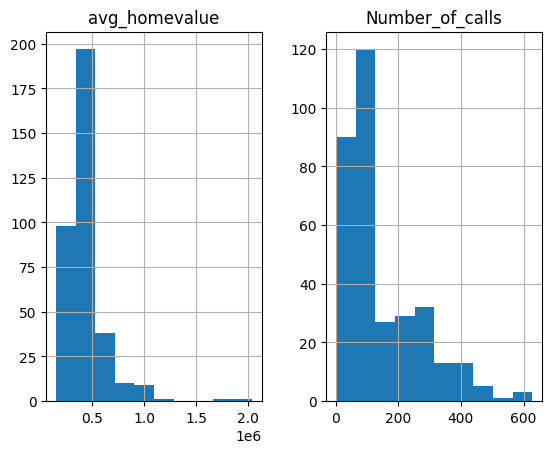

In [225]:
# Histograms of data not transformed
ahv_df.hist()

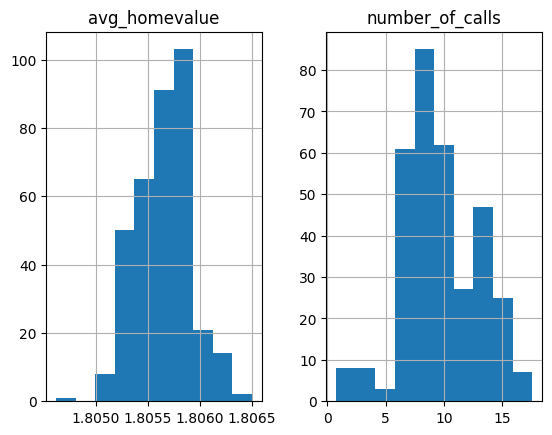

In [226]:
# Histograms of Transformed Data
dataset.hist()
pyplot.show()

Text(0.5, 1.0, 'Scatterplot of Transformed Data')

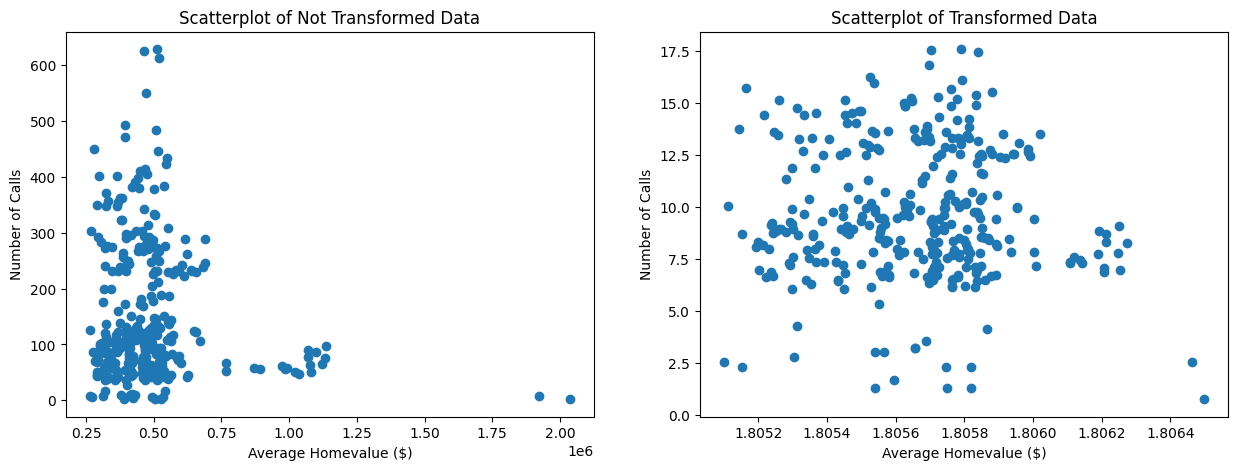

In [227]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Not Transformed
scatter1 = ax[0].scatter(model_df['avg_homevalue'], model_df['Number_of_calls'])
ax[0].set_xlabel("Average Homevalue ($)")
ax[0].set_ylabel("Number of Calls")
ax[0].set_title("Scatterplot of Not Transformed Data")

# Transformed
scatter2 = ax[1].scatter(dataset['avg_homevalue'], dataset['number_of_calls'])
ax[1].set_xlabel("Average Homevalue ($)")
ax[1].set_ylabel("Number of Calls")
ax[1].set_title("Scatterplot of Transformed Data")

Text(0, 0.5, 'Number of Calls')

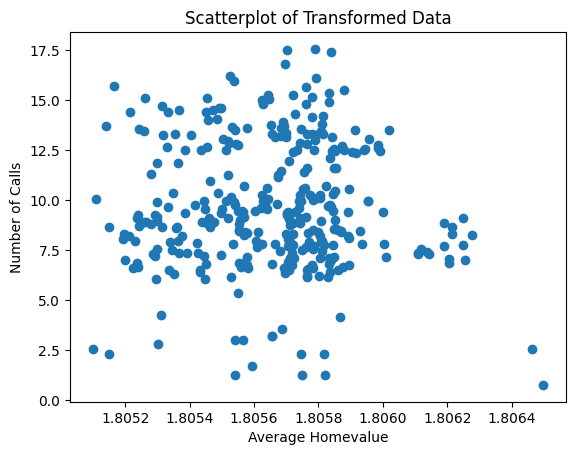

In [228]:
plt.scatter(dataset['avg_homevalue'], dataset['number_of_calls'])

plt.title("Scatterplot of Transformed Data")
plt.xlabel("Average Homevalue")
plt.ylabel("Number of Calls")

Text(0, 0.5, 'Number of Calls')

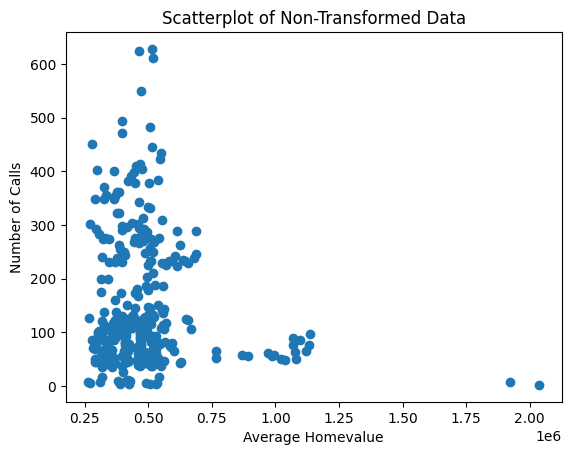

In [229]:
plt.scatter(model_df['avg_homevalue'], model_df['Number_of_calls'])

plt.title("Scatterplot of Non-Transformed Data")
plt.xlabel("Average Homevalue")
plt.ylabel("Number of Calls")


## Changing Lambda

Box-Cox Equation:

$$y_i = \begin{cases}
      \frac{y_i^\lambda - 1}{\lambda} & \lambda \neq 0 \\
      \ln(y_i) & \lambda = 0 \\
   \end{cases}$$

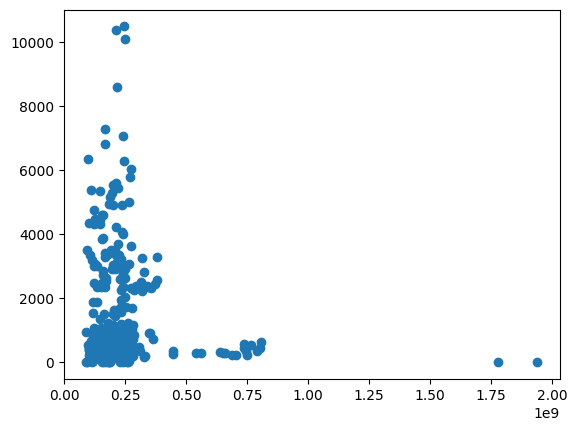

In [230]:
lmbda = 1.5

x = model_df['avg_homevalue']
y = model_df['Number_of_calls']
transform_x = (x**lmbda - 1) / lmbda
transform_y = (y**lmbda - 1) / lmbda

plt.scatter(transform_x, transform_y)

In [231]:
lmbda = 0

x = model_df['avg_homevalue']
y = model_df['Number_of_calls']

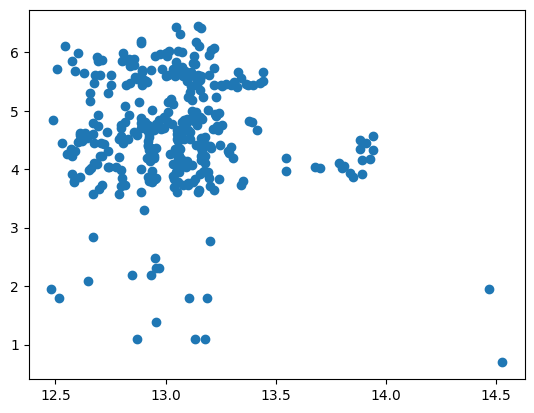

In [232]:
if lmbda != 0:
  transform_x = (x**lmbda - 1) / lmbda
  transform_y = (y**lmbda - 1) / lmbda

  plt.scatter(transform_x, transform_y)
elif lmbda == 0:
  transform_x = np.log(x)
  transform_y = np.log(y)

  plt.scatter(transform_x, transform_y)

In [233]:
transform_x
transform_y

0           NaN
1      5.298317
2      4.110874
3      3.583519
4      4.343805
         ...   
350    4.859812
351    4.753590
352    4.094345
353    4.418841
354    4.382027
Name: Number_of_calls, Length: 355, dtype: float64

In [234]:
transformed = pd.DataFrame(data=zip(transform_x,transform_y),columns=['avg_hv','num_of_calls'])
transformed

,avg_hv,num_of_calls
0,12.085307,NaN
1,12.740290,5.298317
2,12.674570,4.110874
3,12.671143,3.583519
4,12.573235,4.343805
...,...,...
350,13.098161,4.859812
351,13.144014,4.753590
352,13.034771,4.094345
353,13.173967,4.418841


In [235]:
def transform(x, y, lmbda):
  if lmbda != 0:
    tx = (x**lmbda - 1) / lmbda
    ty = (y**lmbda -1) / lmbda

  elif lmbda == 0:
    tx = np.log(x)
    ty = np.log(y)

  return tx, ty

In [236]:
x = model_df['avg_homevalue']
y = model_df['Number_of_calls']
lmbda = -1

In [237]:
transform(x,y,lmbda)

(0      0.999994
 1      0.999997
 2      0.999997
 3      0.999997
 4      0.999997
          ...   
 350    0.999998
 351    0.999998
 352    0.999998
 353    0.999998
 354    0.999998
 Name: avg_homevalue, Length: 355, dtype: float64,
 0           NaN
 1      0.995000
 2      0.983607
 3      0.972222
 4      0.987013
          ...   
 350    0.992248
 351    0.991379
 352    0.983333
 353    0.987952
 354    0.987500
 Name: Number_of_calls, Length: 355, dtype: float64)

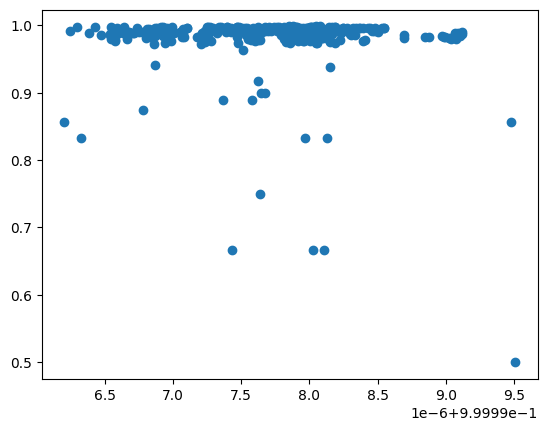

In [238]:
plt.scatter(transform(x, y, lmbda)[0], transform(x,y, lmbda)[1])

In [239]:
def transform(x, y, lmbda1, lmbda2):

  if lmbda1 != 0 and lmbda2 !=0:
    tx = (x**lmbda1 - 1) / lmbda1
    ty = (y**lmbda2 -1) / lmbda2

  elif lmbda1 != 0 and lmbda2 ==0:
    tx = (x**lmbda1 - 1) / lmbda1
    ty = np.log(y)

  elif lmbda1 ==0 and lmbda2 !=0:
    tx = np.log(x)
    ty = (y**lmbda2 -1) / lmbda2

  elif lmbda1 == 0 and lmbda2 == 0:
    tx = np.log(x)
    ty = np.log(y)

  return tx, ty

In [240]:
x = model_df['avg_homevalue']
y = model_df['Number_of_calls']
lmbda1 = -1
lmbda2 = 0

In [241]:
transform(x, y, lmbda1, lmbda2)

(0      0.999994
 1      0.999997
 2      0.999997
 3      0.999997
 4      0.999997
          ...   
 350    0.999998
 351    0.999998
 352    0.999998
 353    0.999998
 354    0.999998
 Name: avg_homevalue, Length: 355, dtype: float64,
 0           NaN
 1      5.298317
 2      4.110874
 3      3.583519
 4      4.343805
          ...   
 350    4.859812
 351    4.753590
 352    4.094345
 353    4.418841
 354    4.382027
 Name: Number_of_calls, Length: 355, dtype: float64)

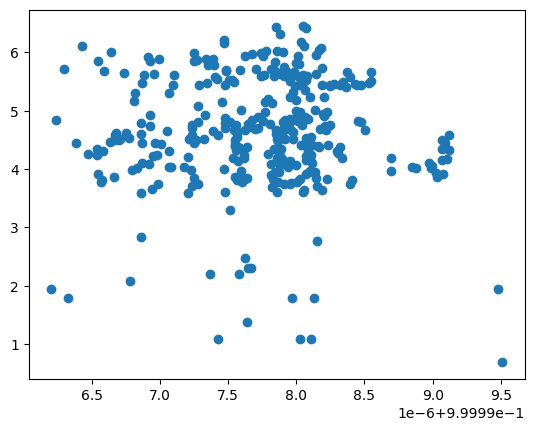

In [242]:
plt.scatter(transform(x, y, lmbda1, lmbda2)[0], transform(x,y, lmbda1, lmbda2)[1])

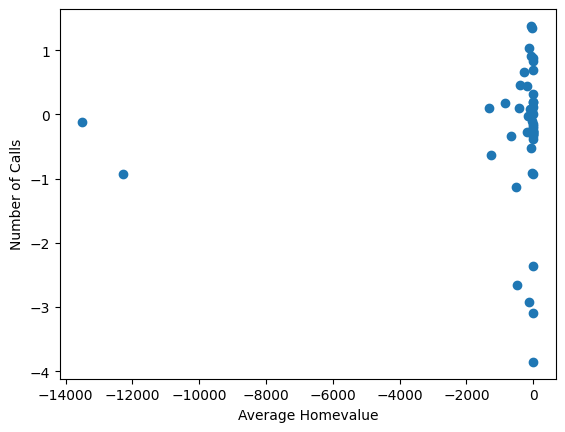

In [243]:
def plot_transformed_data(lmbda1, lmbda2):
  '''
  lmbda1: parameter for the x-variable's power transform
  lmbda2: parameter for the y-variable's power transform
  '''
  tx, ty = transform(x, y, lmbda1, lmbda2)
  plt.scatter(tx, ty)
  plt.xlabel('Average Homevalue')
  plt.ylabel('Number of Calls')
  plt.show()

# Create sliders for lmbda1 and lmbda2
lmbda1_slider = widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description='lmbda1:')
lmbda2_slider = widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description='lmbda2:')

# Interactively plot the transformed data
interact(plot_transformed_data, lmbda1=lmbda1_slider, lmbda2=lmbda2_slider)

### Standardizing Data

In [244]:
import scipy
from scipy import stats

# Z-Score using scipy
zscore_ahv = stats.zscore(model_df['avg_homevalue'])
zscore_ahv

0     -1.555590
1     -0.724508
2     -0.834514
3     -0.840054
4     -0.990577
         ...   
350    0.019637
351    0.135699
352   -0.132298
353    0.214440
354    0.558793
Name: avg_homevalue, Length: 355, dtype: float64

In [245]:
zscore_noc = stats.zscore(model_df['Number_of_calls'])
zscore_noc

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
350   NaN
351   NaN
352   NaN
353   NaN
354   NaN
Name: Number_of_calls, Length: 355, dtype: float64

In [246]:
model_df['Number_of_calls'].isnull().sum()

22

In [247]:
noc = model_df['Number_of_calls'].replace(np.nan, 0)
noc

0        0.0
1      200.0
2       61.0
3       36.0
4       77.0
       ...  
350    129.0
351    116.0
352     60.0
353     83.0
354     80.0
Name: Number_of_calls, Length: 355, dtype: float64

In [248]:
zscore_noc = stats.zscore(noc)
zscore_noc

0     -1.121022
1      0.499084
2     -0.626890
3     -0.829403
4     -0.497281
         ...   
350   -0.076054
351   -0.181361
352   -0.634990
353   -0.448678
354   -0.472980
Name: Number_of_calls, Length: 355, dtype: float64

In [249]:
x = zscore_ahv
y = zscore_noc

In [250]:
interact(plot_transformed_data, lmbda1=lmbda1_slider, lmbda2=lmbda2_slider)

interactive(children=(FloatSlider(value=0.0, description='lmbda1:', max=5.0, min=-5.0), FloatSlider(value=0.0,…

<function __main__.plot_transformed_data(lmbda1, lmbda2)>

[]

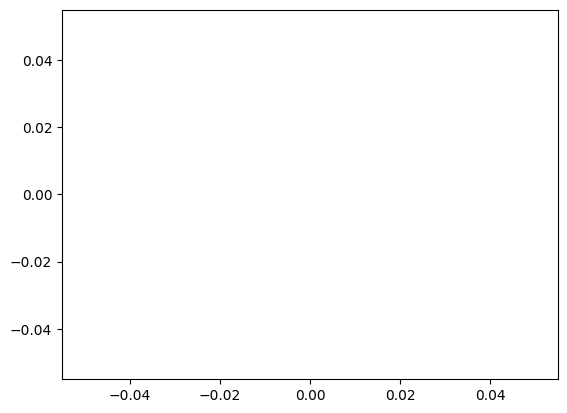

In [251]:
plt.plot()

### Different Equation

$$y_i = \begin{cases}
      \frac{y_i^\lambda}{\lambda(GM(y))^{\lambda - 1}} & \lambda \neq 0 \\
      GM(y)\ln(y_i) & \lambda = 0 \\
   \end{cases}$$

Where
- $GM(y)$: geometric mean
$$\left(\begin{equation*}
  \prod_{i=1}^{n} y_{i}
\end{equation*} \right)^\frac{1}{n}$$

In [252]:
from statistics import geometric_mean

In [253]:
gm_ahv = statistics.geometric_mean(model_df['avg_homevalue'])
gm_noc = statistics.geometric_mean(model_df['Number_of_calls'])

NameError: name 'statistics' is not defined

In [ ]:
def gm_transform(x, lmbda, gm):
  if lmbda == 0:
    tx = gm * np.ln(x)

  else:
    tx = x**lmbda/ (lmbda*gm**(lmbda -1))

# Finding areas of anomalous call volume

## Methodology

We define a region bounded by the ranges of the longitude and latitude of the calls received by CRFR. We then divide this grid into an equal number of steps across the longitude and latitude ranges and calculate the number of calls in each grid cell. Looking at the counts across the grid, we identify cells where the number of calls is above the mean number of calls by a set threshold.

We are also exploring how the high call volume regions vary from year to year. The intent is to identify characteristics of these regions which may correlate with greater utilization of CRFR services (and conversely, characteristics in lower call volume areas).

In [ ]:
def find_grid_boundaries(*,df_calls: pd.DataFrame) -> dict:
    """
    Finds max and min longitude and latitude across the full dataset, so that
    the boundaries don't vary from year to year.
    """

    print("IN: find_grid_boundaries")

    grid_boundaries = {
        "max_lat": df_calls['Latitude'].max(),
        "max_lng": df_calls['Longitude'].max(),
        "min_lat": df_calls['Latitude'].min(),
        "min_lng": df_calls['Longitude'].min(),
    }

    return grid_boundaries

In [ ]:
def call_counts_over_grid(*, df_calls: pd.DataFrame, grid_step_size: int = 10, year: Optional[int]= None) -> pd.DataFrame:
    """
    Finds call counts across grid elements.

    May be restricted to a particular year.
    """

    print("IN: call_counts_over_grid")

    grid_boundaries = find_grid_boundaries(df_calls = df_calls)
    min_lat = grid_boundaries['min_lat']
    min_lng = grid_boundaries['min_lng']
    max_lat = grid_boundaries['max_lat']
    max_lng = grid_boundaries['max_lng']

    range_lat = max_lat - min_lat
    range_lng = max_lng - min_lng

    if year is not None:
        df_calls[df_calls['Incident Year'] == year]


    long_list = []
    lat_list = []
    for i in range(grid_step_size):
        long_list.append(min_lng + (range_lng/grid_step_size)* i)
        lat_list.append(min_lat + (range_lat/grid_step_size)* i)

    counts_df = pd.DataFrame(columns=["latitude", "longitude", "call_count"])
    for longitude in long_list:
        for latitude in lat_list:
            # print(f"lat = {latitude}, long = {longitude}")
            df_grid = df_calls[(df_calls['Longitude'] >= longitude) & (df_calls['Longitude'] <= longitude + long_range/grid_step_size) & (df_calls['Latitude'] >= latitude) & (df_calls['Latitude'] <= latitude + lat_range/grid_step_size)]
            df_grid.head
            new_call_entry = pd.DataFrame({"latitude": [latitude], "longitude": [longitude], "call_count": [df_grid.shape[0]]})
            counts_df = pd.concat([counts_df, new_call_entry], ignore_index=True)

    return counts_df



In [ ]:
def anomalies(*, call_count_grid: pd.DataFrame, threshold: float = 1.0) -> pd.DataFrame:

    from statistics import mean, stdev

    print("IN: anomalies")


    mean_counts = mean(call_count_grid['call_count'])
    counts_stdev = stdev(call_count_grid['call_count'])

    anomalous_cells = call_count_grid[call_count_grid['call_count'] >= (mean_counts + threshold*counts_stdev)]

    return anomalous_cells



In [ ]:
import time
df_calls = pd.read_excel(os.path.join(pathCRFR, 'Incident_Data_CLEAN.xlsx'))


In [ ]:
# one record had a positive longitude (not in Castle Rock) so it has been excluded
df_calls = df_calls[df_calls['Longitude'] < 0]

call_count_grid = call_counts_over_grid(df_calls=df_calls)
anomalous_cells = anomalies(call_count_grid=call_count_grid, threshold=2.)
anomalous_cells.shape



# Conclusion

Words